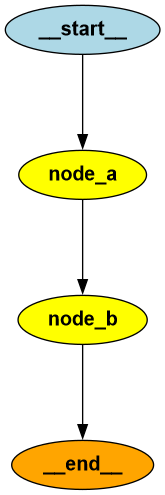

{'foo': 'b', 'bar': ['a', 'b']}

In [6]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import InMemorySaver
from typing import Annotated
from typing_extensions import TypedDict
from operator import add
from IPython.display import Image, display

"""
1. Định nghĩa State & Reducer
State là kiểu dictionary với 2 trường:
- foo: string (chuỗi)
- bar: list of string, nhưng đặc biệt có thêm reducer là add (tức là mỗi lần update, sẽ cộng dồn/nối list thay vì ghi đè)
"""
class State(TypedDict):
    foo: str
    bar: Annotated[list[str], add]
"""
2. Định nghĩa các node
- node_a: luôn trả về foo="a" và bar=["a"].
- node_b: luôn trả về foo="b" và bar=["b"].
"""
def node_a(state: State):
    return {"foo": "a", "bar": ["a"]}

def node_b(state: State):
    return {"foo": "b", "bar": ["b"]}

"""
3. Xây dựng workflow
Tạo workflow: START → node_a → node_b → END
"""
workflow = StateGraph(State)
workflow.add_node(node_a)
workflow.add_node(node_b)
workflow.add_edge(START, "node_a")
workflow.add_edge("node_a", "node_b")
workflow.add_edge("node_b", END)

"""
4. Thêm checkpointer
- Sử dụng InMemorySaver để lưu trạng thái (state) của từng bước vào bộ nhớ (RAM).
- Cho phép bạn giữ lại state, hoặc khôi phục workflow với thread_id bất kỳ.
"""
checkpointer = InMemorySaver()
graph = workflow.compile(checkpointer=checkpointer)

## Display graph
try:
    display(Image(graph.get_graph().draw_png()))
except Exception:
    pass
"""
5. Chạy workflow
- Bắt đầu với state ban đầu: {"foo": ""} (không có bar).
- config có thread_id giúp xác định một session/workflow duy nhất.
"""
config = {"configurable": {"thread_id": "1"}}

graph.invoke({"foo": ""}, config)

Bước 1: START → node_a

- Nhận input state: {"foo": ""}.

- Trả về: {"foo": "a", "bar": ["a"]}.

- Lúc này state:
{"foo": "a", "bar": ["a"]}

Bước 2: node_a → node_b

- Nhận state: {"foo": "a", "bar": ["a"]}.

- node_b trả về: {"foo": "b", "bar": ["b"]}

- Reducer hoạt động:

    - foo (không có reducer): bị ghi đè thành "b"

    - bar (dùng reducer add): ["a"] + ["b"] = ["a", "b"]
- State sau khi chạy xong:
{"foo": "b", "bar": ["a", "b"]}

In [7]:
print(graph.get_state(config))
print(list(graph.get_state_history(config)))

StateSnapshot(values={'foo': 'b', 'bar': ['a', 'b']}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f042d40-847b-676f-8002-f67e72a257de'}}, metadata={'source': 'loop', 'writes': {'node_b': {'foo': 'b', 'bar': ['b']}}, 'step': 2, 'parents': {}, 'thread_id': '1'}, created_at='2025-06-06T12:44:48.790308+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f042d40-847b-676e-8001-404a35ad9219'}}, tasks=(), interrupts=())
[StateSnapshot(values={'foo': 'b', 'bar': ['a', 'b']}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f042d40-847b-676f-8002-f67e72a257de'}}, metadata={'source': 'loop', 'writes': {'node_b': {'foo': 'b', 'bar': ['b']}}, 'step': 2, 'parents': {}, 'thread_id': '1'}, created_at='2025-06-06T12:44:48.790308+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f042d40-847b-676e-8001-404a35ad9219'}}, ta